In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.metrics import r2_score, accuracy_score, roc_curve
from sklearn.model_selection import LeaveOneOut
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from math import pi
import pandas
import time
from numpy.linalg import pinv
import gc
% matplotlib notebook
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(threshold=np.inf)
plt.rc('animation', html='html5')
plt.rcParams["figure.figsize"] = 14, 8

def printmd(string):
    display(Markdown(string))

Глобальный поиск. Будем пытаться оптимизировать значение функции, которую мы знаем:

In [2]:
foo = lambda x, y: 20 * np.exp(-((x - 2.5)**2 + (y + 1.5)**2) / 5) + 3 * (1 + (np.sin(0.08 * pi * x * y))**2) + 3 * np.log(2 + (10 * (x - 2.4))**4 + (10 * (y + 1.3))**4) / (1 + ((x**2 + y**2) / 100)**0.1)

### task 1.1

Визуализируйте функцию.

<IPython.core.display.Javascript object>


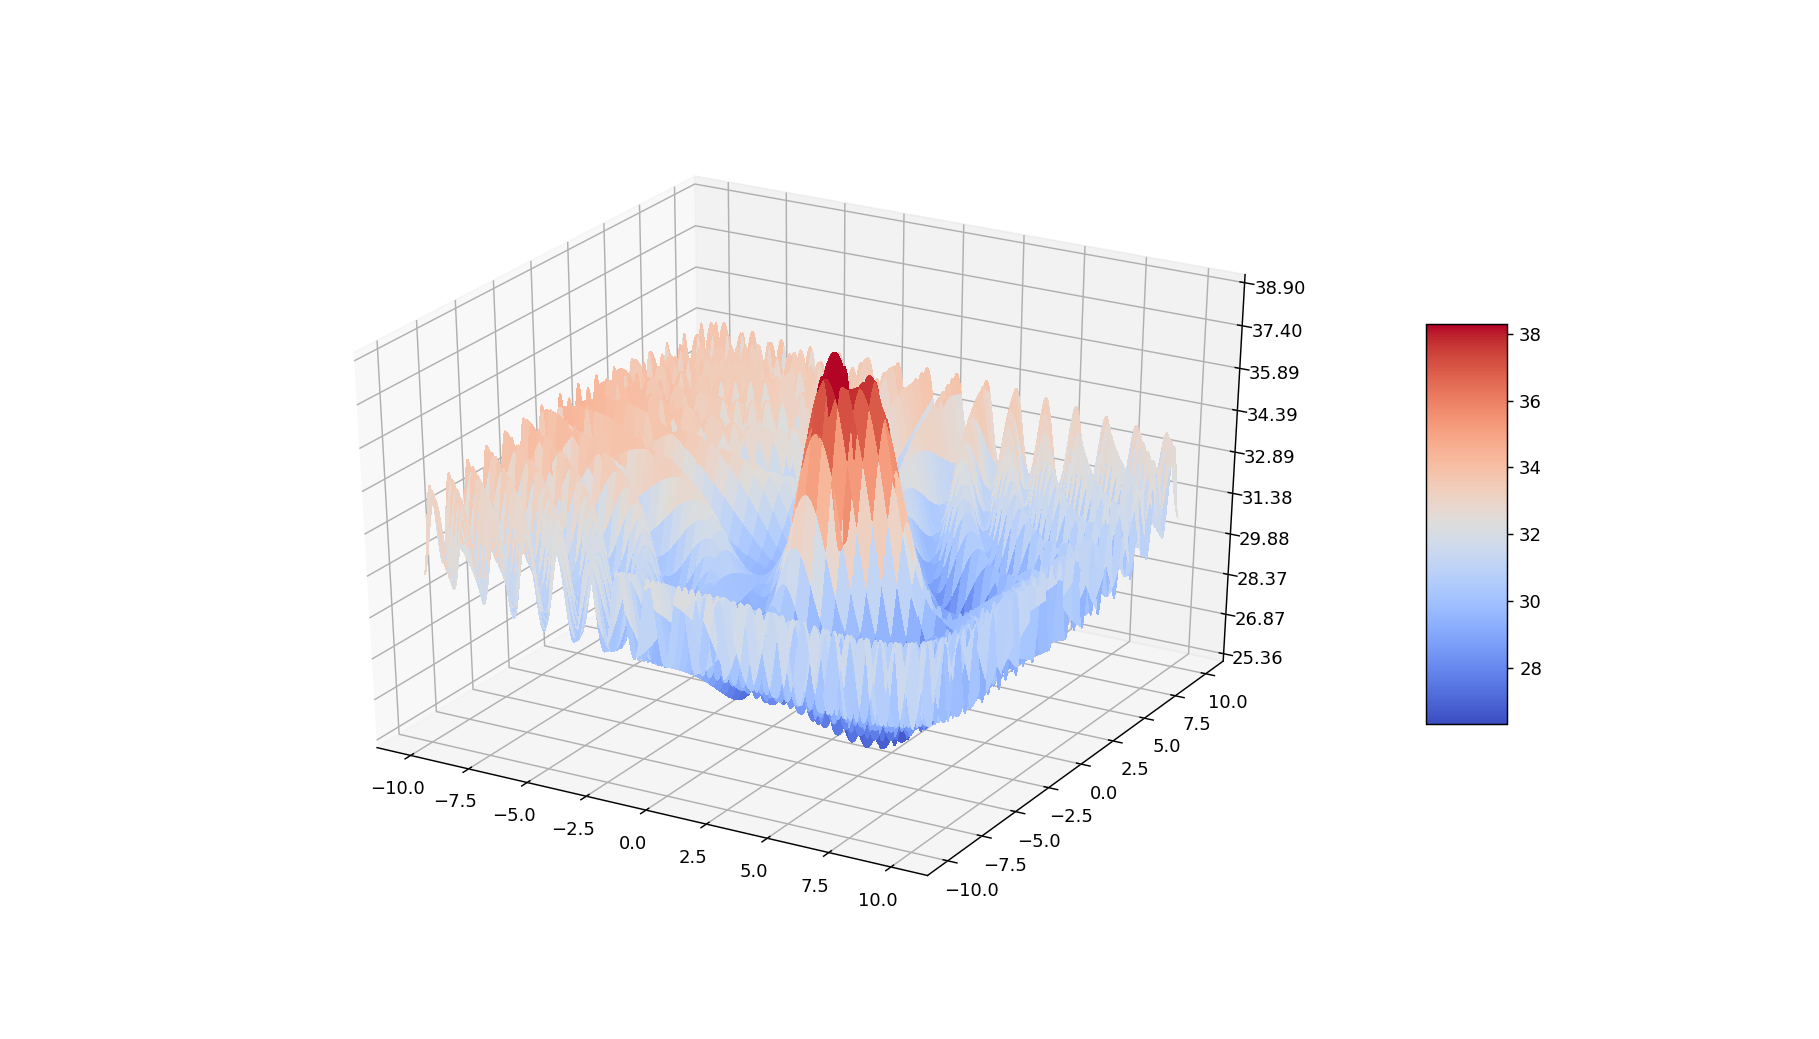

In [9]:
def draw(a=1):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    X    = np.linspace(-10, 10, 400)
    Y    = np.linspace(-10, 10, 400)
    X, Y = np.meshgrid(X, Y)
    Z    = foo(X, Y)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False, alpha=a)

    # Customize the z axis.
    # ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    return ax
    
draw(); plt.show()

### task 1.2

Найдите максимум функции с помощью алгоритма Монте-Карло.

foo(2.487, -2.355) = 38.895741393752395


<IPython.core.display.Javascript object>


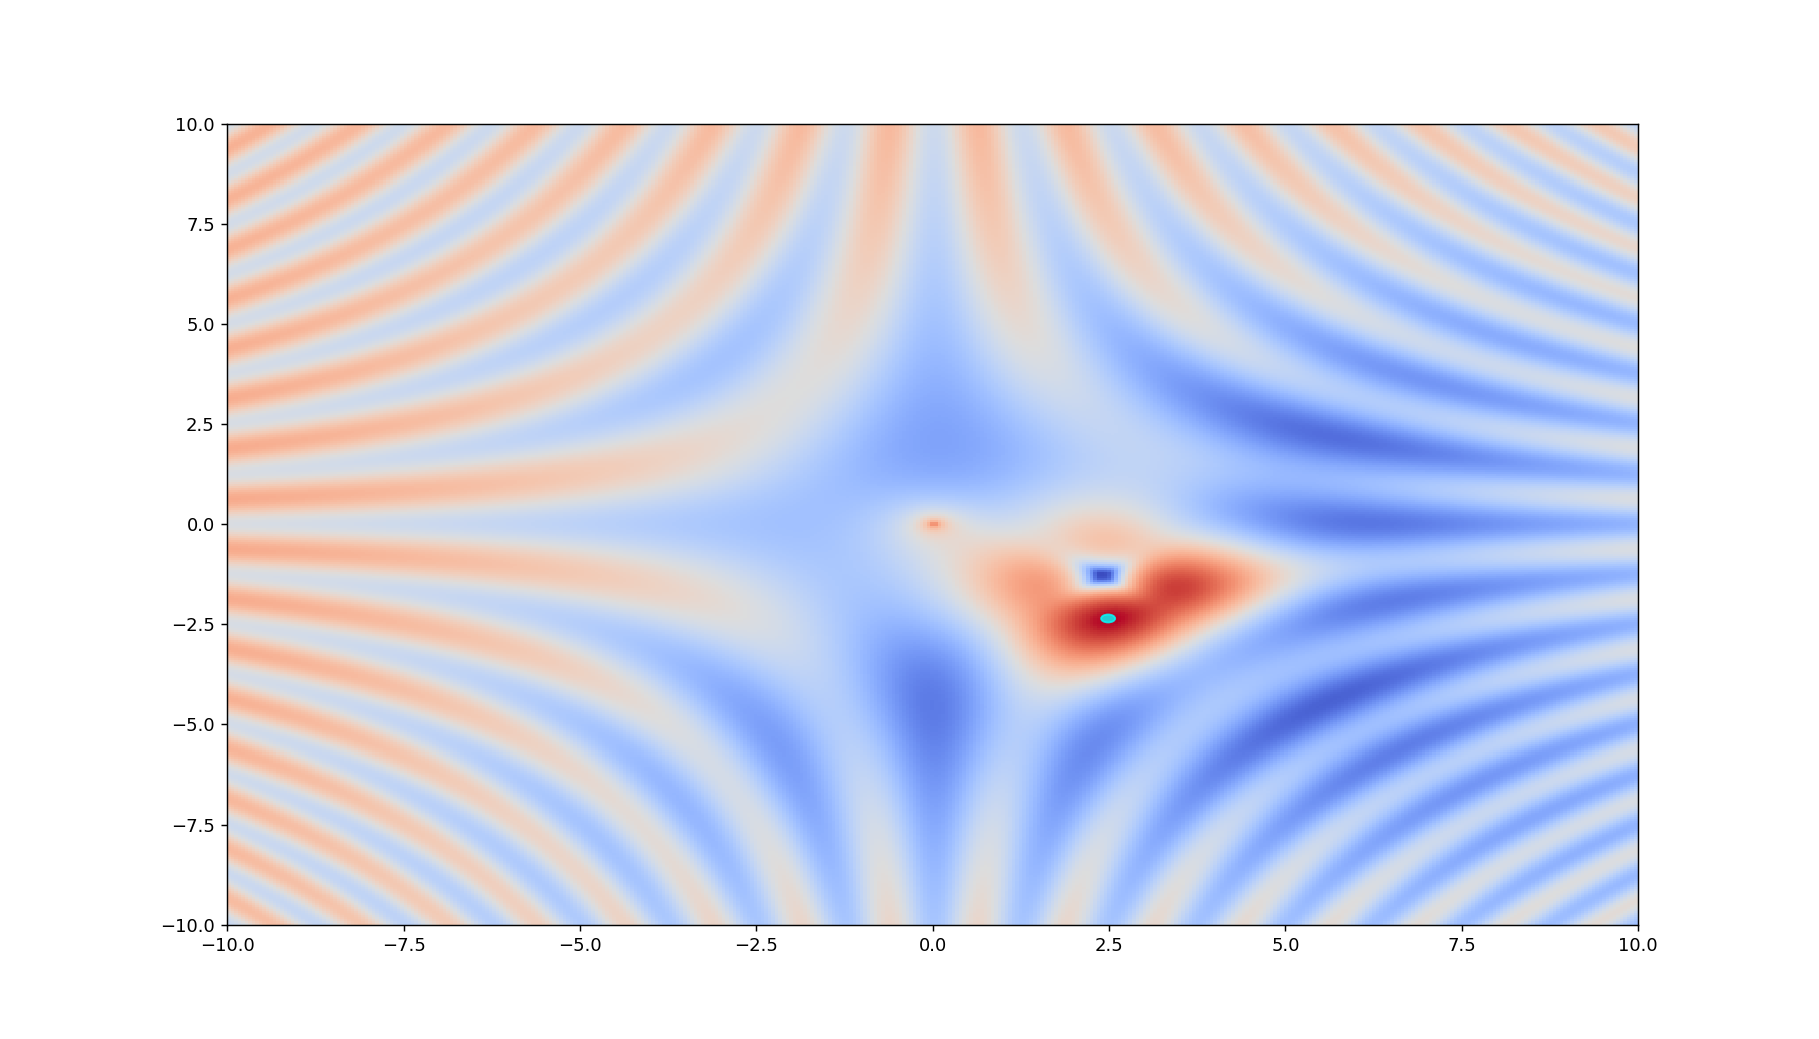

In [10]:
ps   = np.random.uniform(-100, 100, (2, 1000000))
vals = foo(*ps)
idx  = np.argmax(vals)
x, y = ps.T[idx]
z    = vals[idx]
print(f'foo({x:.3f}, {y:.3f}) = {z}')
# draw(0.4).scatter(*[x, y, z], c='red', s=200); plt.show()

X    = np.linspace(-10, 10, 400)
Y    = np.linspace(-10, 10, 400)
X, Y = np.meshgrid(X, Y)
Z    = foo(X, Y)

plt.figure()
ax = plt.gca(); ax.cla()
plt.pcolormesh(X, Y, Z, cmap=cm.coolwarm)
ax.add_artist(plt.Circle((x, y), 0.1, color='cyan', alpha=0.8))

### task 2

Найдите максимум функции с помощью алгоритма кросс-энтропийного поиска, изображая распределение на каждом шаге.

<IPython.core.display.Javascript object>


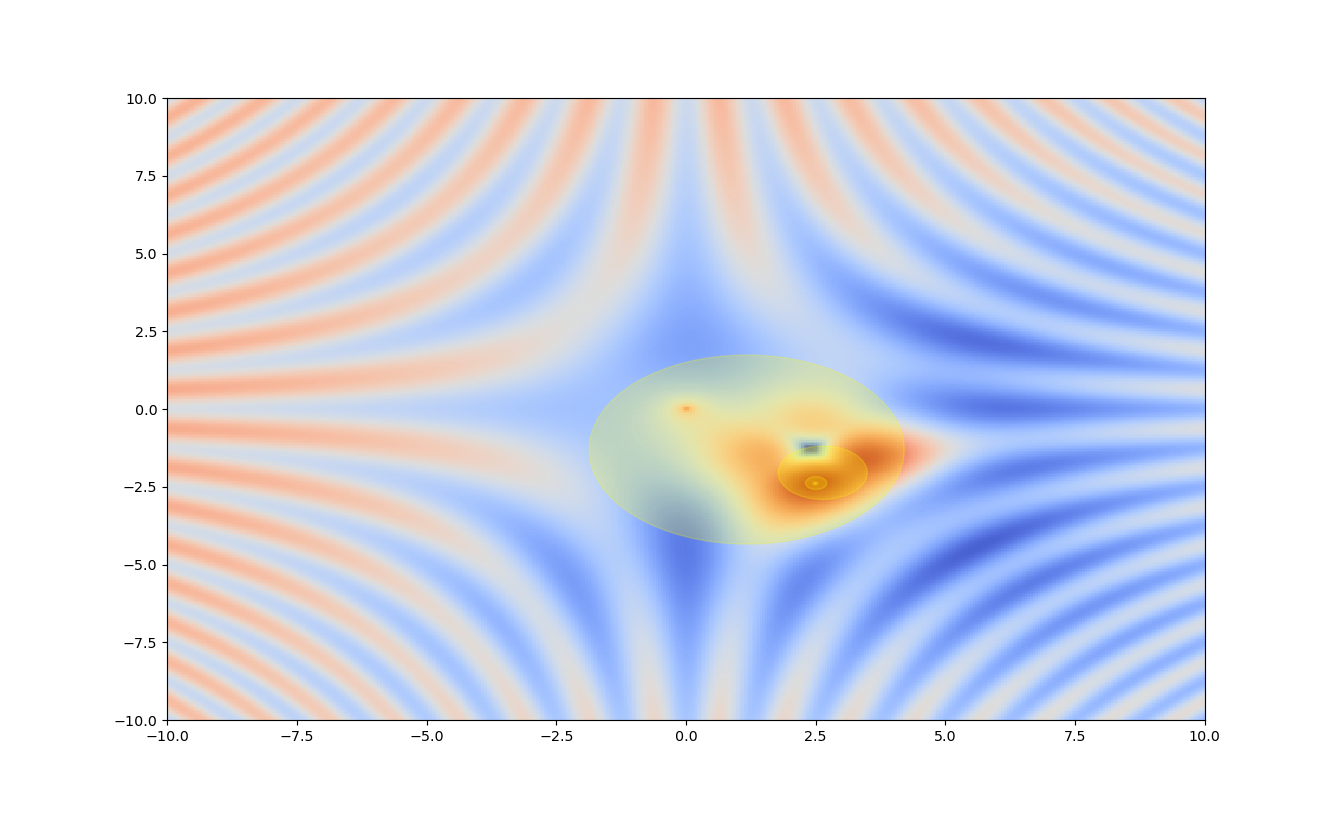

m (1.171, -1.300), s (3.038, 1.954)
m (2.637, -2.046), s (0.859, 0.617)
m (2.509, -2.380), s (0.207, 0.162)
m (2.495, -2.390), s (0.046, 0.038)
m (2.495, -2.390), s (0.010, 0.009)

foo(2.495, -2.390) = 38.90456932150289


In [159]:
X    = np.linspace(-10, 10, 400)
Y    = np.linspace(-10, 10, 400)
X, Y = np.meshgrid(X, Y)
Z    = foo(X, Y)


def search(n=100_000, n_best=10_000, iters=5):   
    plt.figure()
    ax = plt.gca(); ax.cla()
    plt.pcolormesh(X, Y, Z, cmap=cm.coolwarm)
    
    mx, my = 0, 0
    sx, sy = 3, 3
    
    for i in range(iters):
        # make a square (mx, my, mx + sx, my + sy)
        xs = np.random.randn(n) * sx + mx;
        ys = np.random.randn(n) * sy + my;

        # take the biggest values
        vals = func(xs, ys)
        idxs = np.argsort(vals)[::-1][:n_best]
        
        # move square a bit
        mx, my = np.mean(xs[idxs]), np.mean(ys[idxs])
        sx, sy = np.std(xs[idxs]),  np.std(ys[idxs])
        
        ax.add_artist(plt.Circle((mx, my), sx, color='yellow', alpha=0.23))
        print(f'm ({mx:.3f}, {my:.3f}), s ({sx:.3f}, {sy:.3f})')
        
    print(f'\nfoo({mx:.3f}, {my:.3f}) = {func(mx, my)}')
        
search()
plt.show()

<br><br><br><br><br><br><br><br>
Локальный поиск. Одним из классических примеров задач для локального поиска
является задача коммивояжёра – нахождение кратчайшего пути, проходящего через
все определенные точки.

В файле `tsp.csv` записаны x и y координаты точек, через которые нужно пройти.
Расстояние между точками – L1 метрика (как на улицах Манхэттена, например).
Во всех задачах нужно изобразить путь и его длину.

In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(threshold=np.inf)
plt.rc('animation', html='html5')
plt.rcParams["figure.figsize"] = 14, 14
import matplotlib


df = pd.read_csv('tsp.csv')
D  = df.drop('1', axis=1).as_matrix()

### task 3

Найдите лучший путь с помощью алгоритма hill climbing.

total sum:  9065


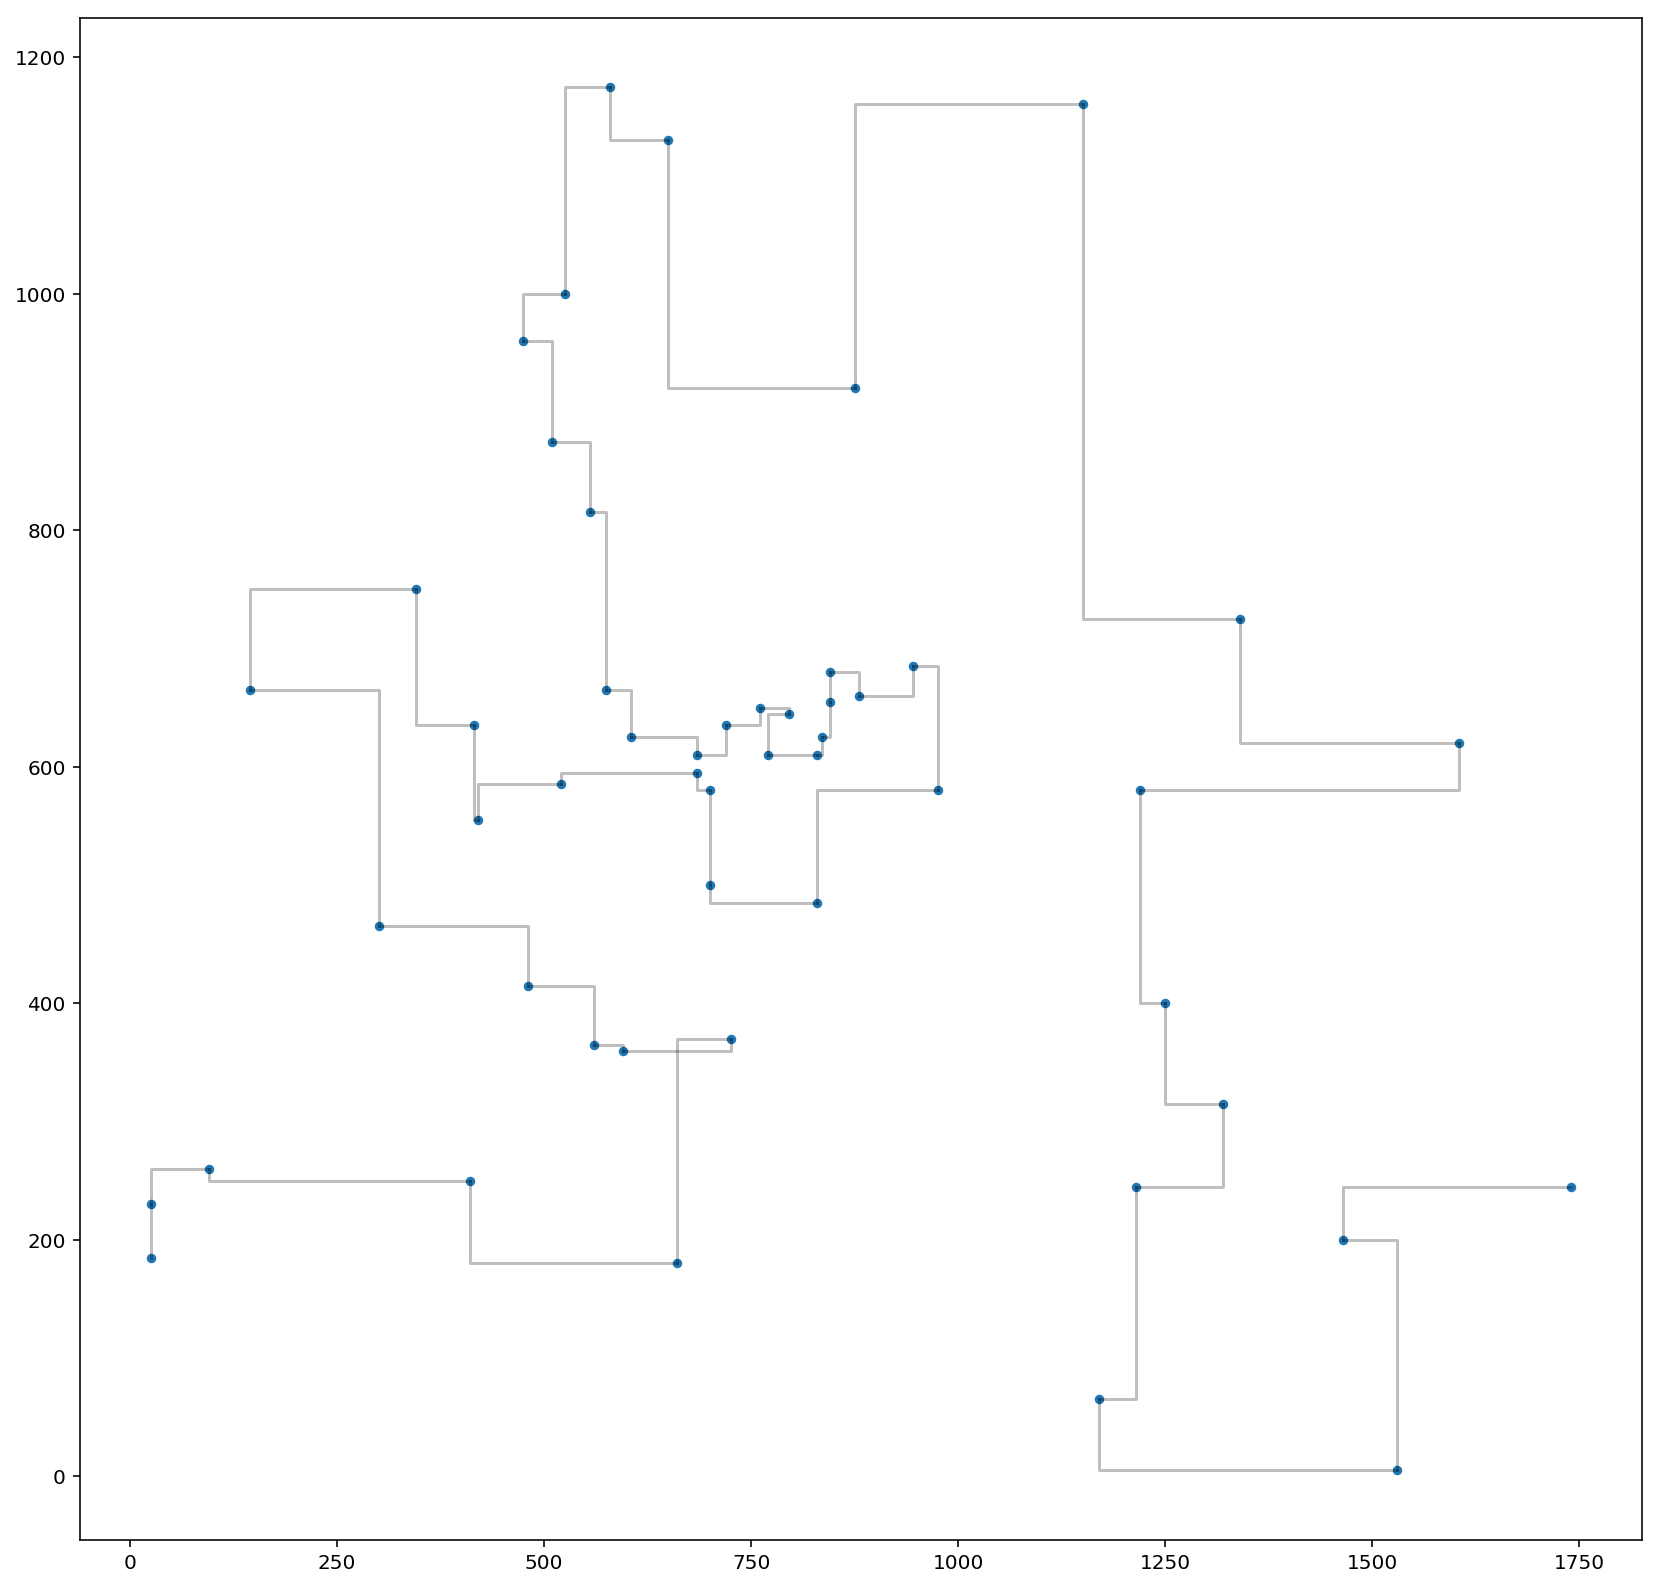

In [40]:
def cost(): return np.abs(D[p[:-1]] - D[p[1:]]).sum()

def d(i, j): return np.abs(D[p[i]] - D[p[j]]).sum()
    
def optimize():
    global p
    ans    = cost()
    change = True
    
    while change:
        change = False

        for i in range(len(p)):
            for j in range(i + 1, len(p)):
                new = ans
                if i > 0:          new += d(i - 1, j) - d(i - 1, i)
                if j < len(p) - 1: new += d(i, j + 1) - d(j, j + 1)

                if new < ans:
                    ans = new
                    p[i : j + 1] = p[i : j + 1][::-1]
                    change = True

                    
# run 20 times, take the best
best = np.inf, None
for i in range(20):
    p = np.random.permutation(len(D))
    optimize()
    
    if cost() < best[0]:
        best = cost(), np.copy(p)

        
# print results
print('total sum: ', best[0])

p = best[1]
plt.scatter(*D.T, s=14)
for i in range(len(D) - 1):
    x1, y1 = D[p[i]]
    x2, y2 = D[p[i + 1]]
    plt.plot([x1, x2, x2], [y1, y1, y2], 'black', alpha=0.25)

### task 4

Найдите лучший путь с помощью алгоритма отжига.

### task 5

Найдите лучший путь с помощью генетического алгоритма.